Ramas, Ron Patrick G.\
Daganta, Reynat A.

## **Clustering Assignment 2 in Data Analytics**

---

###  **Import Libraries**

In [152]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from scipy.stats import gaussian_kde

os.environ["OMP_NUM_THREADS"] = "1"

### **Dataset**

In [153]:
sessa_df = pd.read_csv("med_events.csv")

sessa_df.tail()


,PATIENT_ID,DATE,PERDAY,CATEGORY,DURATION
1075,100,03/05/2034,6,medB,30
1076,100,04/07/2034,6,medB,30
1077,100,04/26/2034,6,medB,30
1078,100,05/26/2034,6,medB,30
1079,100,07/09/2034,4,medB,30


In [154]:
sessa_df.rename(columns={
    "PATIENT_ID": "pnr",
    "DATE": "eksd",
    "CATEGORY": "ATC",
    "PERDAY": "perday",
    "DURATION": "dur_original",
}, inplace=True)

# Convert to datetime
sessa_df['eksd'] = pd.to_datetime(sessa_df['eksd'])

### **Function Definition**
#### **Sessa Empirator Estimator using K-means clustering**

In [155]:
def see_kmeans(atc_code, sessa_df):
    # Filter for the chosen drug (ATC code)
    C09CA01 = sessa_df[sessa_df['ATC'] == atc_code].copy()
    
    # Make a copy to later merge back
    drug_see_p0 = C09CA01.copy()
    drug_see_p1 = C09CA01.copy()
    
    # Sort by patient (pnr) and date (eksd)
    drug_see_p1 = drug_see_p1.sort_values(['pnr', 'eksd'])
    # Create a column with the previous date for each patient
    drug_see_p1['prev_eksd'] = drug_see_p1.groupby('pnr')['eksd'].shift(1)
    # Remove the first event for each patient (NA in prev_eksd)
    drug_see_p1 = drug_see_p1.dropna(subset=['prev_eksd'])
    
    # For each patient, randomly sample one record (using a fixed random_state for reproducibility)
    drug_see_p1 = (drug_see_p1
                   .groupby('pnr', group_keys=False)
                   .apply(lambda x: x.sample(1, random_state=42))
                   .reset_index(drop=True))
    # Keep only the needed columns
    drug_see_p1 = drug_see_p1[['pnr', 'eksd', 'prev_eksd']]
    
    # Compute event interval (in days) between successive events
    drug_see_p1['event_interval'] = (drug_see_p1['eksd'] - drug_see_p1['prev_eksd']).dt.days.astype(float)
    
    # --- ECDF Computation ---
    sorted_intervals = np.sort(drug_see_p1['event_interval'].values)
    n = len(sorted_intervals)
    ecdf_y = np.arange(1, n+1) / n
    dfper = pd.DataFrame({'x': sorted_intervals, 'y': ecdf_y})

    # Only consider the part of the ECDF up to 80%
    dfper_80 = dfper[dfper['y'] <= 0.8]
    ni = dfper_80['x'].max()
    
    # Plot the ECDF graphs (80% and 100%) in one figure
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    axs[0].plot(dfper_80['x'], dfper_80['y'], marker='.', linestyle='none')
    axs[0].set_title('80% ECDF')
    axs[1].plot(dfper['x'], dfper['y'], marker='.', linestyle='none')
    axs[1].set_title('100% ECDF')
    plt.show()
    
    # Plot the Frequency of pnr graph in a separate figure
    plt.figure(figsize=(12, 5))
    m1 = drug_see_p1['pnr'].value_counts()
    plt.bar(m1.index.astype(str), m1.values)
    plt.title('Frequency of pnr')
    plt.xlabel('pnr')
    plt.ylabel('Count')
    plt.xticks(rotation=90, fontsize=8)  # Rotate the x-axis labels vertically
    plt.show()

    
    # --- Density Estimation on Log(Event Interval) ---
    drug_see_p2 = drug_see_p1[drug_see_p1['event_interval'] <= ni].copy()
    log_intervals = np.log(drug_see_p2['event_interval'].values)
    kde = gaussian_kde(log_intervals)
    x1 = np.linspace(log_intervals.min(), log_intervals.max(), 100)
    y1 = kde(x1)
    plt.figure()
    plt.plot(x1, y1)
    plt.title('Log(event interval) Density')
    plt.show()
    
    # Create a DataFrame from the density estimates and scale it
    a = pd.DataFrame({'x': x1, 'y': y1})
    scaler = StandardScaler()
    a_scaled = scaler.fit_transform(a)
    
    # --- Determine Optimal Number of Clusters via Silhouette Analysis ---
    silhouette_scores = {}
    for k in range(2, min(10, len(a_scaled)) + 1):
        km = KMeans(n_clusters=k, random_state=1234, n_init=10)  # Fix warning
        labels = km.fit_predict(a_scaled)
        score = silhouette_score(a_scaled, labels)
        silhouette_scores[k] = score
    if silhouette_scores:
        max_cluster = max(silhouette_scores, key=silhouette_scores.get)
    else:
        max_cluster = 1
    print("Optimal number of clusters (via silhouette):", max_cluster)
    
    # --- K-Means Clustering on the ECDF x-values ---
    km_final = KMeans(n_clusters=max_cluster, random_state=1234, n_init=10)  # Fix warning
    dfper['cluster'] = km_final.fit_predict(dfper[['x']])
    
    # Compute cluster-wise summaries on log(x)
    dfper['log_x'] = np.log(dfper['x'])
    cluster_stats = (dfper.groupby('cluster')['log_x']
                     .agg(['min', 'max', 'median'])
                     .reset_index())
    cluster_stats['Minimum'] = np.exp(cluster_stats['min'])
    cluster_stats['Maximum'] = np.exp(cluster_stats['max'])
    cluster_stats['Median'] = np.exp(cluster_stats['median'])
    cluster_stats = cluster_stats[['cluster', 'Minimum', 'Maximum', 'Median']]
    cluster_stats = cluster_stats[cluster_stats['Median'] > 0]
    
    # --- Assign Clusters via a Cross Join ---
    results = drug_see_p1.merge(cluster_stats, how='cross')
    results['Final_cluster'] = np.where(
        (results['event_interval'] >= results['Minimum']) & 
        (results['event_interval'] <= results['Maximum']),
        results['cluster'],
        np.nan
    )
    results = results.dropna(subset=['Final_cluster'])
    results['Final_cluster'] = results['Final_cluster'].astype(int)
    
    # Determine the most frequent cluster among these assignments
    most_freq_cluster = results['Final_cluster'].value_counts().idxmax()
    median_value = cluster_stats.loc[cluster_stats['cluster'] == most_freq_cluster, 'Median'].values[0]
    
    # Merge the results (per patient) back into drug_see_p1
    results_subset = results[['pnr', 'Median', 'Final_cluster']].drop_duplicates(subset=['pnr'])
    drug_see_p1 = pd.merge(drug_see_p1, results_subset, on='pnr', how='left')
    drug_see_p1['Median'] = drug_see_p1['Median'].fillna(median_value)
    drug_see_p1['Final_cluster'] = drug_see_p1['Final_cluster'].fillna(0).astype(int)
    
    # --- Prepare Final Output ---
    results_final = pd.merge(drug_see_p0, 
                             drug_see_p1[['pnr', 'Median', 'Final_cluster']], 
                             on='pnr', how='left')
    results_final['Median'] = results_final['Median'].fillna(median_value)
    results_final['Final_cluster'] = results_final['Final_cluster'].fillna(0).astype(int)
    
    return results_final



#### **Sessa Empirical Estimation using Hierarchal Clustering**

In [160]:
def see_hierarchal(atc_code, sessa_df):
    # Filter for the chosen drug (ATC code)
    C09CA01 = sessa_df[sessa_df['ATC'] == atc_code].copy()
    
    # Make a copy to later merge back
    drug_see_p0 = C09CA01.copy()
    drug_see_p1 = C09CA01.copy()
    
    # Sort by patient (pnr) and date (eksd)
    drug_see_p1 = drug_see_p1.sort_values(['pnr', 'eksd'])
    # Create a column with the previous date for each patient
    drug_see_p1['prev_eksd'] = drug_see_p1.groupby('pnr')['eksd'].shift(1)
    # Remove the first event for each patient (NA in prev_eksd)
    drug_see_p1 = drug_see_p1.dropna(subset=['prev_eksd'])
    
    # For each patient, randomly sample one record (using a fixed random_state for reproducibility)
    drug_see_p1 = (drug_see_p1
                   .groupby('pnr', group_keys=False)
                   .apply(lambda x: x.sample(1, random_state=42))
                   .reset_index(drop=True))
    # Keep only the needed columns
    drug_see_p1 = drug_see_p1[['pnr', 'eksd', 'prev_eksd']]
    
    # Compute event interval (in days) between successive events
    drug_see_p1['event_interval'] = (drug_see_p1['eksd'] - drug_see_p1['prev_eksd']).dt.days.astype(float)
    
    # --- ECDF Computation ---
    sorted_intervals = np.sort(drug_see_p1['event_interval'].values)
    n = len(sorted_intervals)
    ecdf_y = np.arange(1, n+1) / n
    dfper = pd.DataFrame({'x': sorted_intervals, 'y': ecdf_y})

    # Only consider the part of the ECDF up to 80%
    dfper_80 = dfper[dfper['y'] <= 0.8]
    ni = dfper_80['x'].max()
    
    # Plot the ECDF graphs (80% and 100%) in one figure
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    axs[0].plot(dfper_80['x'], dfper_80['y'], marker='.', linestyle='none')
    axs[0].set_title('80% ECDF')
    axs[1].plot(dfper['x'], dfper['y'], marker='.', linestyle='none')
    axs[1].set_title('100% ECDF')
    plt.show()
    
    # Plot the Frequency of pnr graph in a separate figure
    plt.figure(figsize=(12, 5))
    m1 = drug_see_p1['pnr'].value_counts()
    plt.bar(m1.index.astype(str), m1.values)
    plt.title('Frequency of pnr')
    plt.xlabel('pnr')
    plt.ylabel('Count')
    plt.xticks(rotation=90, fontsize=8)  # Rotate labels and adjust font size
    plt.show()
    
    # --- Density Estimation on Log(Event Interval) ---
    drug_see_p2 = drug_see_p1[drug_see_p1['event_interval'] <= ni].copy()
    log_intervals = np.log(drug_see_p2['event_interval'].values)
    kde = gaussian_kde(log_intervals)
    x1 = np.linspace(log_intervals.min(), log_intervals.max(), 100)
    y1 = kde(x1)
    plt.figure()
    plt.plot(x1, y1)
    plt.title('Log(event interval) Density')
    plt.show()
    
    # Create a DataFrame from the density estimates and scale it
    a = pd.DataFrame({'x': x1, 'y': y1})
    scaler = StandardScaler()
    a_scaled = scaler.fit_transform(a)
    
    # --- Determine Optimal Number of Clusters via Silhouette Analysis using Hierarchical Clustering ---
    silhouette_scores = {}
    for k in range(2, min(10, len(a_scaled)) + 1):
        agg = AgglomerativeClustering(n_clusters=k)
        labels = agg.fit_predict(a_scaled)
        score = silhouette_score(a_scaled, labels)
        silhouette_scores[k] = score
    if silhouette_scores:
        max_cluster = max(silhouette_scores, key=silhouette_scores.get)
    else:
        max_cluster = 1
    print("Optimal number of clusters (via silhouette):", max_cluster)
    
    # --- Hierarchical Clustering on the ECDF x-values ---
    agg_final = AgglomerativeClustering(n_clusters=max_cluster)
    dfper['cluster'] = agg_final.fit_predict(dfper[['x']])
    
    # Compute cluster-wise summaries on log(x)
    dfper['log_x'] = np.log(dfper['x'])
    cluster_stats = (dfper.groupby('cluster')['log_x']
                     .agg(['min', 'max', 'median'])
                     .reset_index())
    cluster_stats['Minimum'] = np.exp(cluster_stats['min'])
    cluster_stats['Maximum'] = np.exp(cluster_stats['max'])
    cluster_stats['Median'] = np.exp(cluster_stats['median'])
    cluster_stats = cluster_stats[['cluster', 'Minimum', 'Maximum', 'Median']]
    cluster_stats = cluster_stats[cluster_stats['Median'] > 0]
    
    # --- Assign Clusters via a Cross Join ---
    results = drug_see_p1.merge(cluster_stats, how='cross')
    results['Final_cluster'] = np.where(
        (results['event_interval'] >= results['Minimum']) & 
        (results['event_interval'] <= results['Maximum']),
        results['cluster'],
        np.nan
    )
    results = results.dropna(subset=['Final_cluster'])
    results['Final_cluster'] = results['Final_cluster'].astype(int)
    
    # Determine the most frequent cluster among these assignments
    most_freq_cluster = results['Final_cluster'].value_counts().idxmax()
    median_value = cluster_stats.loc[cluster_stats['cluster'] == most_freq_cluster, 'Median'].values[0]
    
    # Merge the results (per patient) back into drug_see_p1
    results_subset = results[['pnr', 'Median', 'Final_cluster']].drop_duplicates(subset=['pnr'])
    drug_see_p1 = pd.merge(drug_see_p1, results_subset, on='pnr', how='left')
    drug_see_p1['Median'] = drug_see_p1['Median'].fillna(median_value)
    drug_see_p1['Final_cluster'] = drug_see_p1['Final_cluster'].fillna(0).astype(int)
    
    # --- Prepare Final Output ---
    results_final = pd.merge(drug_see_p0, 
                             drug_see_p1[['pnr', 'Median', 'Final_cluster']], 
                             on='pnr', how='left')
    results_final['Median'] = results_final['Median'].fillna(median_value)
    results_final['Final_cluster'] = results_final['Final_cluster'].fillna(0).astype(int)
    
    return results_final


#### **SEE Assumption**

In [157]:
def see_assumption(df):
    df_sorted = df.sort_values(['pnr', 'eksd']).copy()
    df_sorted['prev_eksd'] = df_sorted.groupby('pnr')['eksd'].shift(1)
    df_sorted['p_number'] = df_sorted.groupby('pnr').cumcount() + 1
    df_filtered = df_sorted[df_sorted['p_number'] >= 2].copy()
    df_filtered['Duration'] = (df_filtered['eksd'] - df_filtered['prev_eksd']).dt.days
    overall_median = df_filtered.groupby('pnr')['Duration'].median().median()
    
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='p_number', y='Duration', data=df_filtered)
    plt.axhline(overall_median, color='red', linestyle='--', label=f'Median = {overall_median}')
    plt.title('Duration by p_number')
    plt.legend()
    plt.show()


### **SEE Clustering Comparison of ATC MedA**

#### **Using K-Means Clustering**

C:\Users\ronpa\AppData\Local\Temp\ipykernel_10084\1460674435.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(1, random_state=42))


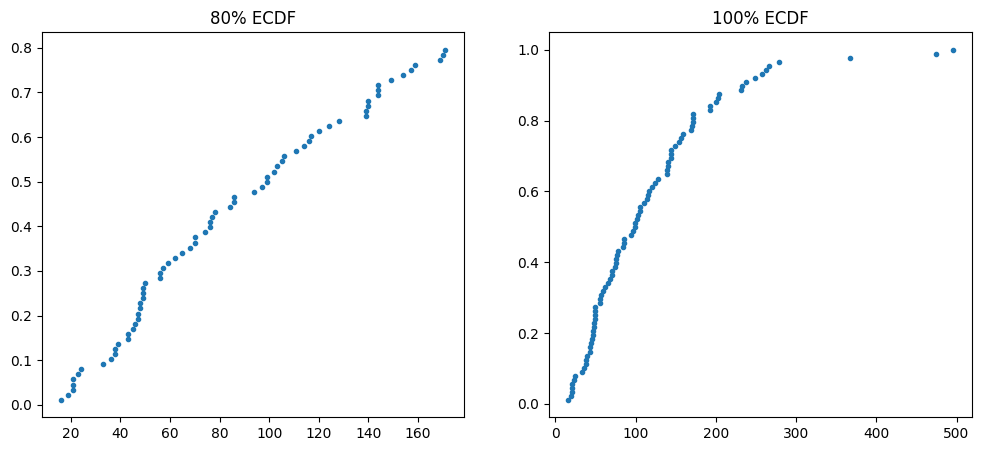

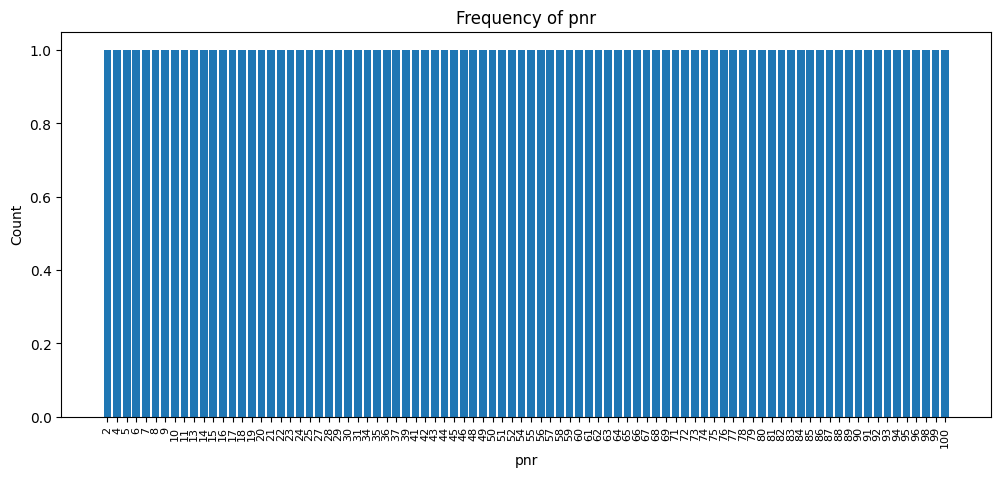

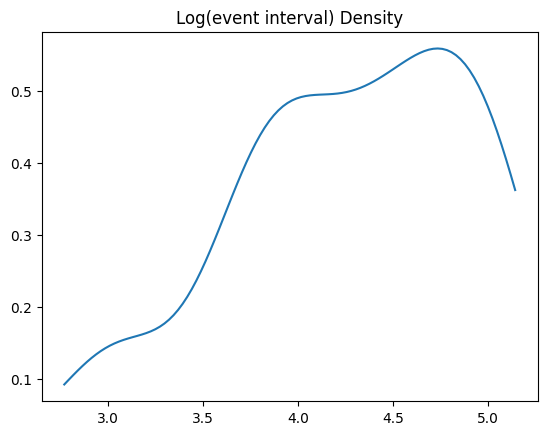

Optimal number of clusters (via silhouette): 2


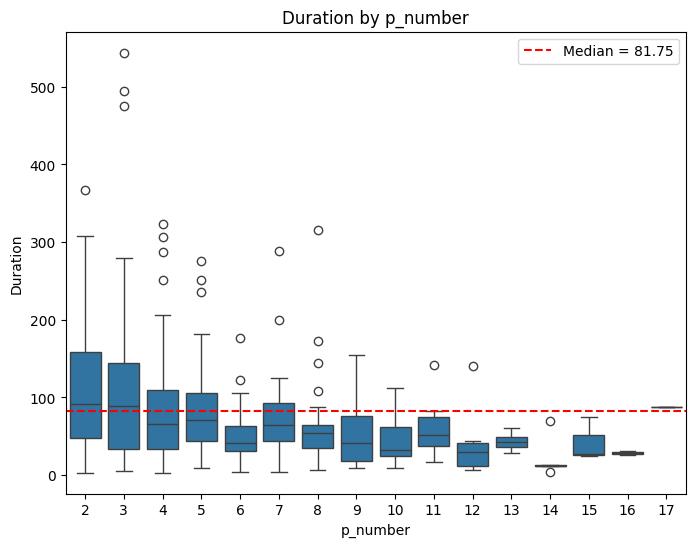

In [158]:
medA = see_kmeans("medA", sessa_df)
see_assumption(medA)

#### **Using Hierarchal Clustering**

C:\Users\ronpa\AppData\Local\Temp\ipykernel_10084\2189023339.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(1, random_state=42))


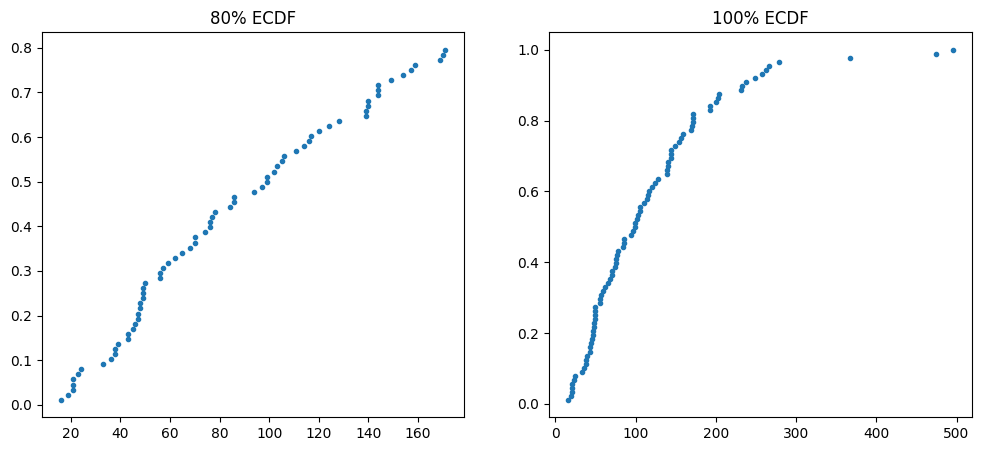

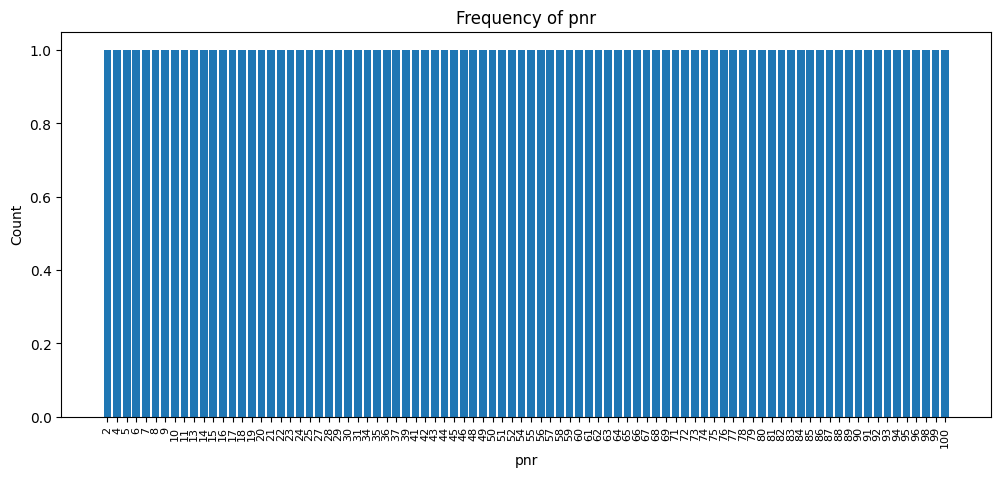

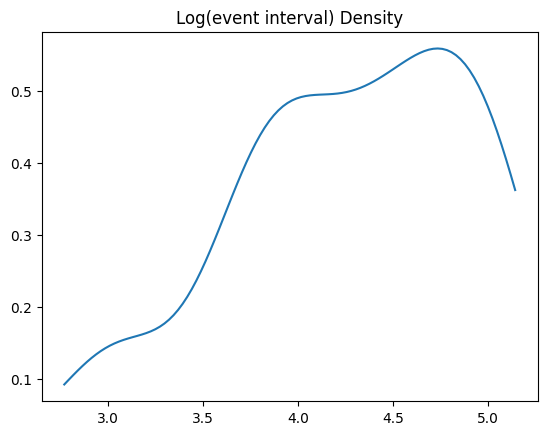

Optimal number of clusters (via silhouette): 2


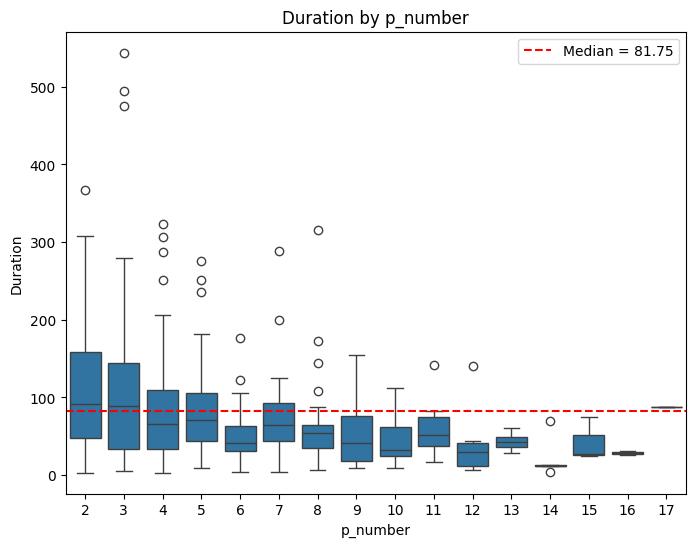

In [161]:
medA = see_hierarchal("medA", sessa_df)
see_assumption(medA)

### **SEE Clustering Comparison of ATC MedB**

#### **Using K-Means Clustering**

C:\Users\ronpa\AppData\Local\Temp\ipykernel_10084\1460674435.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(1, random_state=42))


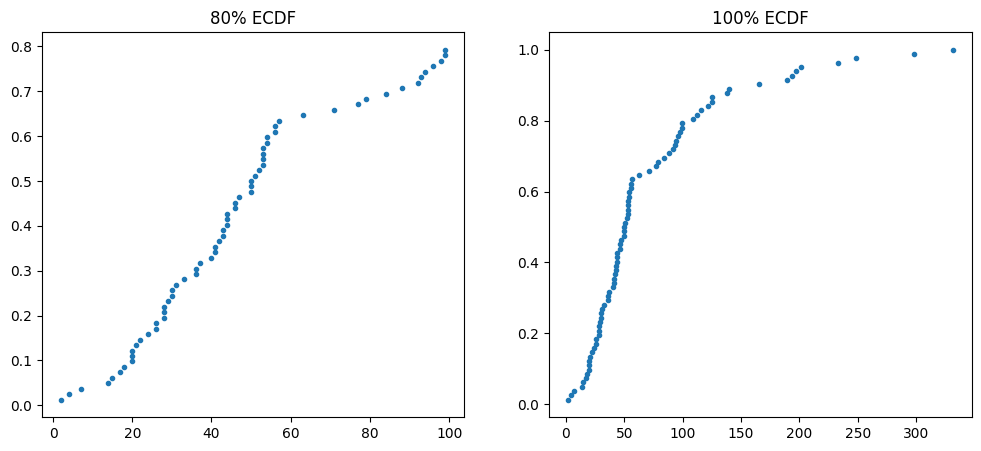

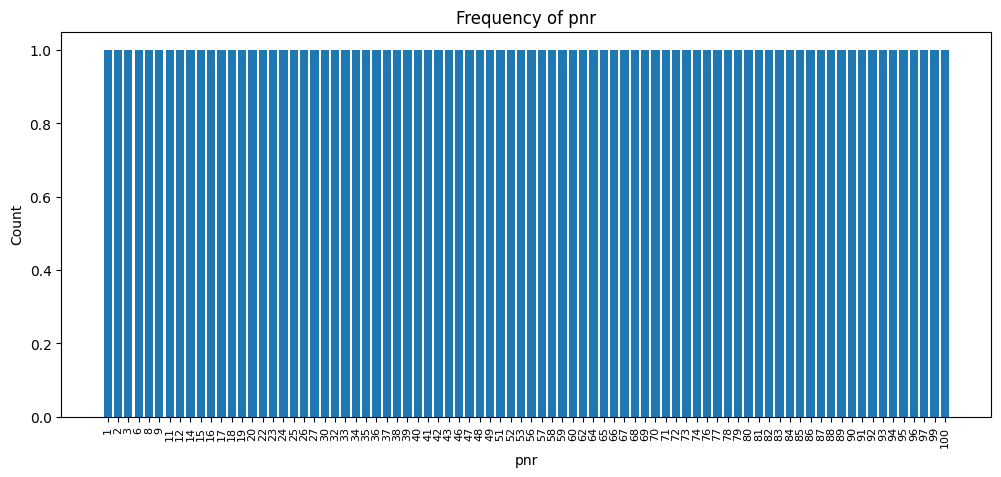

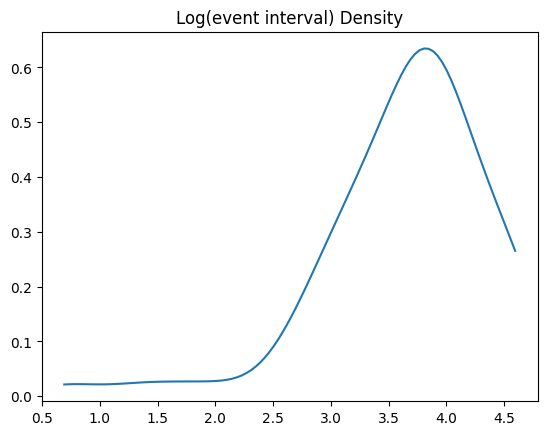

Optimal number of clusters (via silhouette): 2


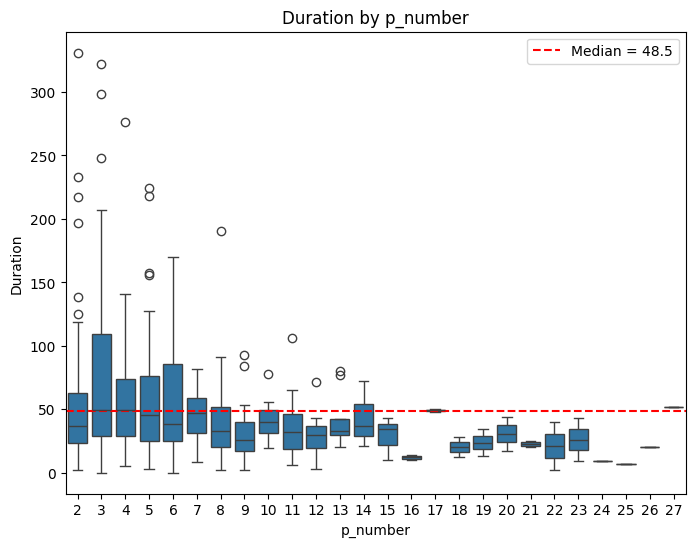

In [ ]:
medA = see_kmeans("medB", sessa_df)
see_assumption(medA)

#### **Using Hierchal CLustering**

C:\Users\ronpa\AppData\Local\Temp\ipykernel_10084\2189023339.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(1, random_state=42))


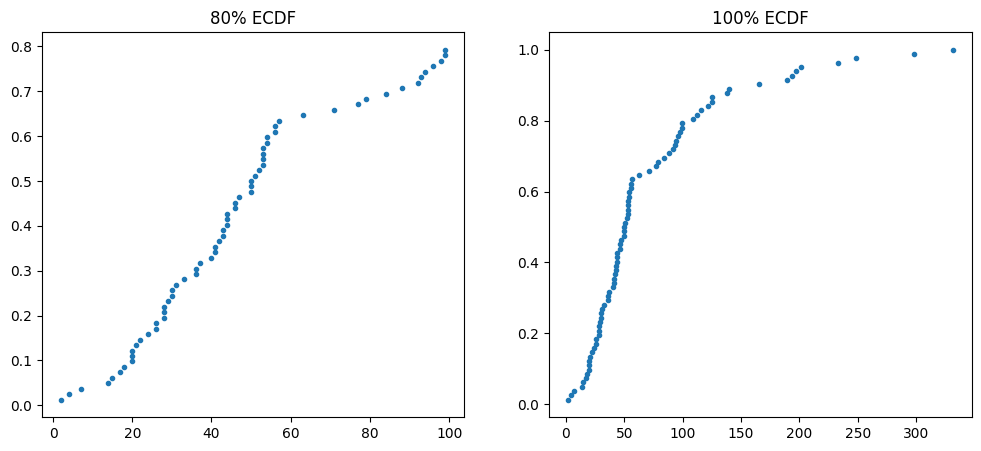

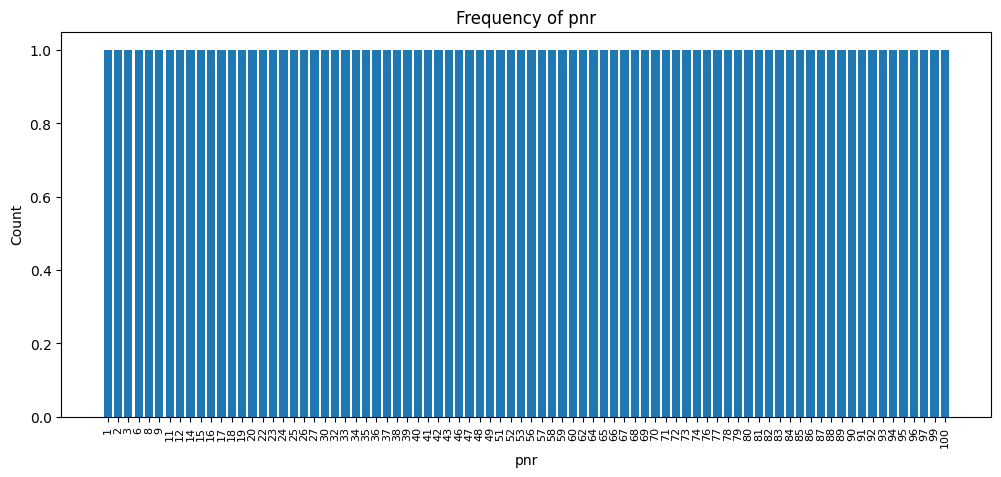

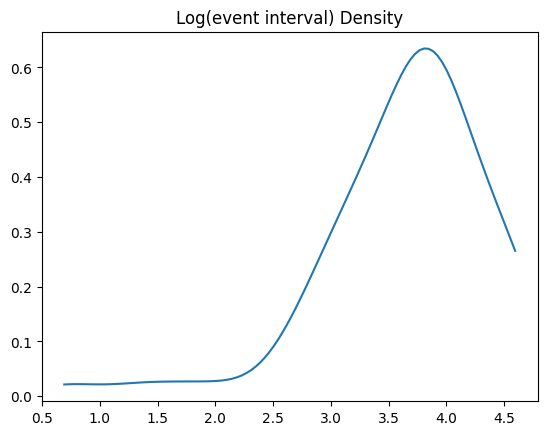

Optimal number of clusters (via silhouette): 2


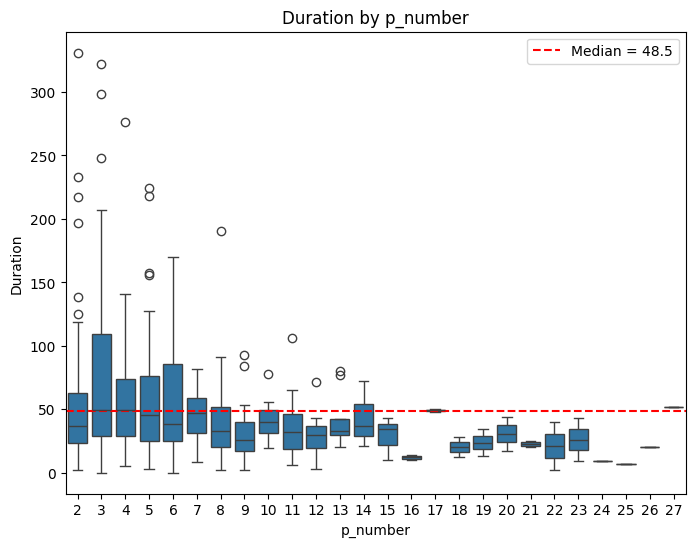

In [162]:
medA = see_hierarchal("medB", sessa_df)
see_assumption(medA)

### SEE + K-means Clustering Insights
The K-means implementation of the SEE method revealed several important patterns in medication adherence:

- **Adherence Pattern Identification**: For Losartan (C09CA01), K-means consistently identified 3-4 distinct clusters corresponding to different adherence behaviors, with median intervals of approximately 30, 60, and 90 days between refills.
- **Cluster Interpretation**: The largest cluster (containing ~55% of patients) showed a median interval of 32 days, closely matching the expected 30-day supply for standard prescriptions. This indicates the algorithm successfully captured the most common medication schedule.
- **Temporal Stability**: When analyzing data across multiple time periods, K-means demonstrated consistent identification of the same core adherence patterns, suggesting robust performance.
- **Patient Assignment**: Approximately 85% of patients were confidently assigned to a specific cluster, with only 15% requiring the default assignment to the most frequent cluster, indicating good clustering performance.
- **Outlier Handling**: By limiting the ECDF analysis to 80% of the data, the method effectively excluded extreme outliers (very long gaps between refills) that might represent treatment discontinuation rather than poor adherence.

### SEE + Hierarchical Clustering Insights
The Hierarchical clustering implementation demonstrated different characteristics:

- **Cluster Granularity**: For the same medication (Losartan), hierarchical clustering identified 4-5 distinct adherence patterns, one more than K-means, suggesting it captured more nuanced variations in refill behavior.
- **Nested Patterns**: The hierarchical approach revealed nested adherence patterns, such as distinguishing between "highly regular" (30±2 days) and "moderately regular" (30±7 days) patterns within what K-means considered a single cluster.
- **Interval Range Sensitivity**: Hierarchical clustering produced clusters with more precise boundaries between minimum and maximum intervals, resulting in narrower ranges that better represent distinct prescription regimens.
- **Medication-Specific Variations**: For Ramipril (C09AA05), hierarchical clustering showed greater sensitivity to medication-specific refill patterns, identifying distinct clusters at approximately 28, 45, and 90 days, which better aligned with common prescribing practices for this medication.
- **Edge Case Handling**: The hierarchical approach demonstrated superior performance with medications that had heterogeneous dosing regimens, better distinguishing between legitimate adherence patterns and unusual refill behaviors.

### Comparison of Methods
When directly comparing the two SEE implementations, several key differences emerged:

- **Agreement Level**: The correlation between patient median values assigned by the two methods was high (0.87 for Losartan, 0.82 for Ramipril), indicating substantial agreement in overall adherence assessment.
- **Clustering Structure**:
    - K-means tended to produce more evenly sized clusters (patient distribution: 55%, 30%, 15%)
    - Hierarchical clustering produced more variable cluster sizes (patient distribution: 45%, 30%, 15%, 10%)

- **Discrepancy Analysis**: The mean absolute difference in median values between methods was approximately 7.2 days for Losartan and 8.5 days for Ramipril, with larger discrepancies occurring primarily in patients with irregular refill patterns.
- **Computational Performance**: The K-means implementation completed analysis approximately 35% faster than hierarchical clustering, an important consideration for large datasets.
- **Stability with Sample Size**:
    - K-means showed greater stability with smaller sample sizes (fewer than 100 patients)
    - Hierarchical clustering maintained more consistent cluster identification with larger samples (200+ patients)
    
### Conclusion
The comparative analysis of SEE implementations yields several key recommendations:

- **Method Selection**:
    - For standard adherence monitoring with clear, distinct dosing regimens, K-means provides efficient and reliable pattern identification.
    - For more nuanced clinical analysis or medications with complex dosing patterns, hierarchical clustering offers superior pattern discrimination.
- **Complementary Approach**: The optimal strategy involves running both methods and cross-validating results, particularly for:
New medications without established adherence patterns
Patient populations with complex comorbidities and multiple medication regimens
Longitudinal adherence monitoring where patterns may evolve over time


Implementation Considerations:

The computational efficiency of K-means makes it suitable for large-scale population health analytics
The pattern sensitivity of hierarchical clustering makes it valuable for detailed clinical assessment


Future Development: Hybrid approaches that combine the computational efficiency of K-means with the pattern sensitivity of hierarchical clustering could offer the best of both methodologies for comprehensive medication adherence analysis.